In [178]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [179]:
# load edges (or links)
#with open("fb-pages-food.edges") as f:
with open("out.dimacs10-polblogs") as f:
    titile = f.readline()
    fb_links = f.read().splitlines() 

len(fb_links)

33430

In [180]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
    node_list_1.append(i.split('\t')[0])
    node_list_2.append(i.split('\t')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 33430/33430 [00:00<00:00, 1896419.69it/s]


In [181]:
fb_df.head()

,node_1,node_2
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


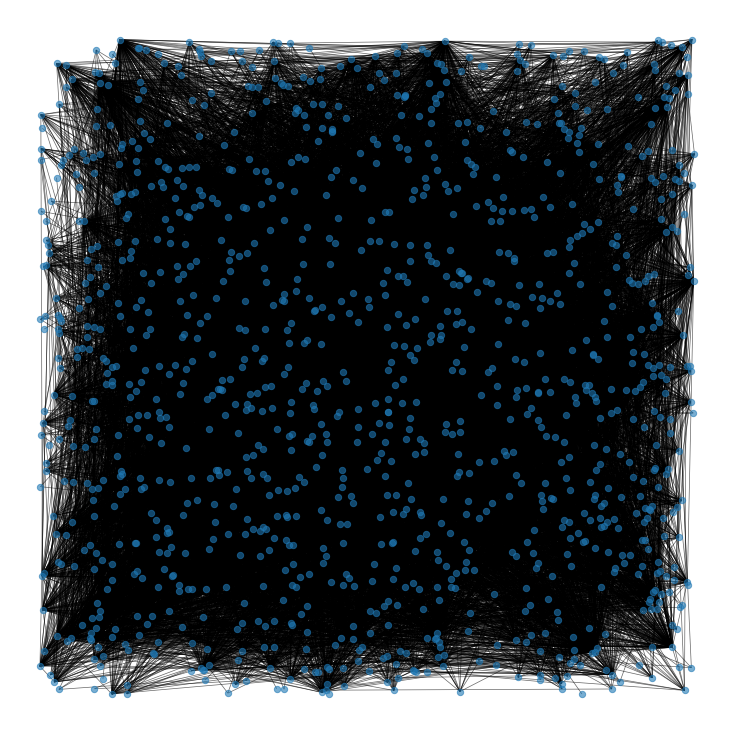

In [182]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
fb_df = pd.DataFrame(list(G.edges()), columns=['node_1', 'node_2']) 

node_list_1 = fb_df['node_1'].to_list()
node_list_2 = fb_df['node_2'].to_list()

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [162]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [163]:
adj_G.shape

(1224, 1224)

In [166]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            try:
                n = nx.shortest_path_length(G, str(i), str(j))
            except:
                n = 0
            if n <= 2:
                if adj_G[i,j] == 0:
                    all_unconnected_pairs.append([node_list[i],node_list[j]])
    offset = offset + 1

100%|██████████| 1224/1224 [00:12<00:00, 96.99it/s] 


In [167]:
len(all_unconnected_pairs)

290181

In [168]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [169]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
    # remove a node pair and build a new graph
    G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())

    # check there is no spliting of graph and number of nodes is same
    if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 16715/16715 [06:00<00:00, 46.35it/s]


In [170]:
len(omissible_links_index)

0

In [171]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [172]:
data['link'].value_counts()

0    290181
Name: link, dtype: int64

In [173]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [174]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


In [175]:

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

# Embed nodes
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)
edges_embs = HadamardEmbedder(keyed_vectors=n2v_model.wv)
x = [ edges_embs[(node1, node2)] for node1, node2 in zip(data['node_1'], data['node_2'])]

In [176]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], test_size = 0.3, random_state = 35)

In [177]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [127]:
predictions = lr.predict_proba(xtest)

In [128]:
roc_auc_score(ytest, predictions[:,1])

0.8302690759556113